In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import glob
from PIL import Image
from tqdm import tqdm
import time
import numpy as np
import IPython.display as ipd

from utils.dataloader import CaptchaDataset

# hyperparameter

In [2]:
EPOCHS = 100
CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if CUDA else 'cpu'
MODEL_PATH = './weights/conv'
BATCH_SIZE = 128
PATIENCE = 10

# dataloader

In [3]:
image_transform = transforms.Compose([
    # transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                      std=[0.229, 0.224, 0.225])
])

dataset = CaptchaDataset('./Large_Captcha_Dataset', isFilter=True, isCrop=True)

In [4]:
for x, y in dataset:
    print(x.shape)
    print(y)
    break

torch.Size([3, 85, 256])
tensor([ 4, 26, 23, 54,  0])


In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [6]:
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# model

In [8]:
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5, padding=2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2)
        self.maxpool3 = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=20480, out_features=512)
        self.linear1 = nn.Linear(in_features=512, out_features=62)
        self.linear2 = nn.Linear(in_features=512, out_features=62)
        self.linear3 = nn.Linear(in_features=512, out_features=62)
        self.linear4 = nn.Linear(in_features=512, out_features=62)
        self.linear5 = nn.Linear(in_features=512, out_features=62)
        self.softmax = nn.Softmax(dim=-1)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        
        x = self.dropout1(x)
        x = self.flatten(x)
        
        x = self.linear(x)
        x = self.dropout2(x)
        
        y1 = self.linear1(x)
        y2 = self.linear2(x)
        y3 = self.linear3(x)
        y4 = self.linear4(x)
        y5 = self.linear5(x)
        
        return y1, y2, y3, y4, y5
        
        
#         input_layer = Input((25, 67, 1))
#         x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
#         x = MaxPooling2D(pool_size=(2, 2))(x)

#         x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
#         x = MaxPooling2D(pool_size=(2, 2))(x)

#         x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
#         x = MaxPooling2D(pool_size=(2, 2))(x)

#         x = Dropout(0.3)(x)
#         x = Flatten()(x)
#         x = Dense(512, activation='relu')(x)
#         x = Dropout(0.3)(x)

#         out = [Dense(10, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]

In [9]:
model = myModel()

In [10]:
if CUDA:
    model = model.cuda()

# train

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [12]:
loss_history = []
val_loss_history = []

In [13]:
model.train()

myModel(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=20480, out_features=512, bias=True)
  (linear1): Linear(in_features=512, out_features=62, bias=True)
  (linear2): Linear(in_features=512, out_features=62, bias=True)
  (linear3): Linear(in_features=512, out_features=62, bias=True)
  (linear4): Linear(in_features=512, out_features=62, bias=True)
  (linear5):

72/100, 82.50 sec/epoch
stop cnt=9/10, current loss=8.9309, val loss=12.2918


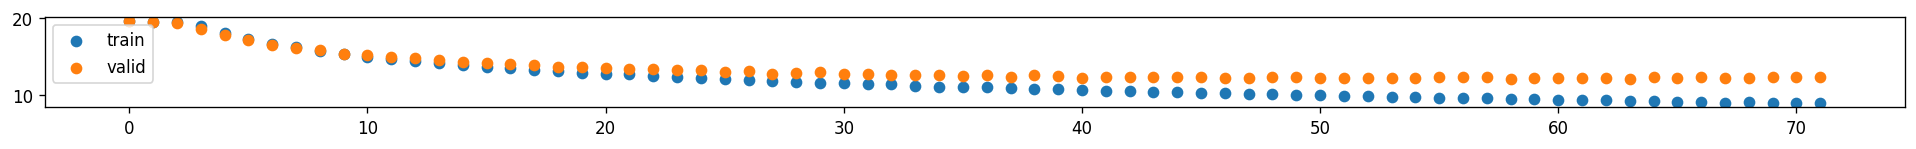

100%|███████████████████████████████████████████| 52/52 [00:08<00:00,  6.40it/s]


In [14]:
min_val_loss = 20.
stop_cnt = 0
for e in range(EPOCHS):
    start_time = time.time()
    current_loss = []
    current_val_loss = []
    
    for (x, y) in tqdm(train_dataloader):
        optimizer.zero_grad()
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]
        
        pred1, pred2, pred3, pred4, pred5 = model(x)

        loss1 = criterion(pred1, y1)
        loss2 = criterion(pred2, y2)
        loss3 = criterion(pred3, y3)
        loss4 = criterion(pred4, y4)
        loss5 = criterion(pred5, y5)
        loss = loss1 + loss2 + loss3 + loss4 + loss5
        current_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    current_loss = np.mean(current_loss).item()
    loss_history.append(current_loss)
    
    for (x, y) in tqdm(val_dataloader):
        with torch.no_grad():
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            
            y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]
            
            pred1, pred2, pred3, pred4, pred5 = model(x)
            
            loss1 = criterion(pred1, y1)
            loss2 = criterion(pred2, y2)
            loss3 = criterion(pred3, y3)
            loss4 = criterion(pred4, y4)
            loss5 = criterion(pred5, y5)
            loss = loss1 + loss2 + loss3 + loss4 + loss5
            current_val_loss.append(loss.item())

    current_val_loss = np.mean(current_val_loss).item()
    val_loss_history.append(current_val_loss)
    
    if current_val_loss < min_val_loss:
        min_val_loss = current_val_loss
        stop_cnt = 0
        torch.save(model.state_dict(), MODEL_PATH)
        
    stop_cnt += 1
    if stop_cnt == PATIENCE:
        break
    
    ipd.clear_output(wait=True)
    print(f"{e+1}/{EPOCHS}, {time.time()-start_time:.2f} sec/epoch")
    print(f"stop cnt={stop_cnt}/{PATIENCE}, current loss={current_loss:.4f}, val loss={current_val_loss:.4f}")
    plt.figure(figsize=(20,1),dpi=120)
    plt.scatter(np.arange(len(loss_history)), loss_history, label='train')
    plt.scatter(np.arange(len(val_loss_history)), val_loss_history, label='valid')
    plt.legend(loc=2)
    plt.show()
    

# test

In [15]:
model.eval()
model.load_state_dict(torch.load(MODEL_PATH))
'done'

'done'

In [16]:
keys = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [17]:
pred_list = [[] for i in range(5)]
true_list = [[] for i in range(5)]

for (x, y) in tqdm(test_dataloader):
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        pred_list[0] += pred1.detach().cpu().tolist()
        pred_list[1] += pred2.detach().cpu().tolist()
        pred_list[2] += pred3.detach().cpu().tolist()
        pred_list[3] += pred4.detach().cpu().tolist()
        pred_list[4] += pred5.detach().cpu().tolist()
        
        true_list[0] += y1.detach().cpu().tolist()
        true_list[1] += y2.detach().cpu().tolist()
        true_list[2] += y3.detach().cpu().tolist()
        true_list[3] += y4.detach().cpu().tolist()
        true_list[4] += y5.detach().cpu().tolist()
        
        # print(pred_list)
        
        # for idx in range(BATCH_SIZE):
        #     plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        #     print(keys[y1[idx]], keys[y2[idx]], keys[y3[idx]], keys[y4[idx]], keys[y5[idx]])
        #     print(keys[pred1[idx]], keys[pred2[idx]], keys[pred3[idx]], keys[pred4[idx]], keys[pred5[idx]])
        #     break
        # break

100%|█████████████████████████████████████████| 129/129 [00:20<00:00,  6.16it/s]


In [18]:
pred_list = np.array(pred_list)
true_list = np.array(true_list)

In [19]:
(pred_list==true_list).shape

(5, 16466)

In [20]:
np.sum(pred_list==true_list, axis=1)/16466

array([0.86292967, 0.53528483, 0.43222398, 0.41023928, 0.73260051])

In [21]:
np.average(np.sum(pred_list==true_list, axis=1)/16466)

0.5946556540750637

# visualization

/tmp/ipykernel_2085722/3964336067.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(50,50))


ValueError: num must be 1 <= num <= 64, not 65

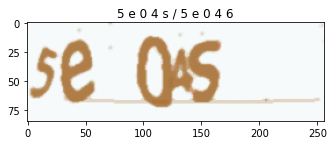

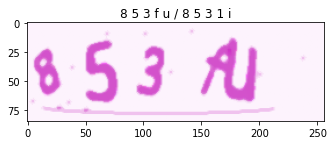

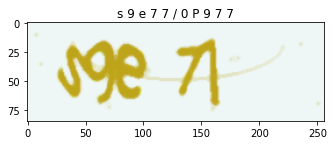

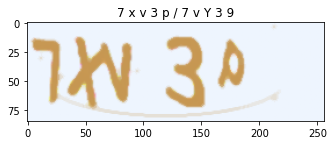

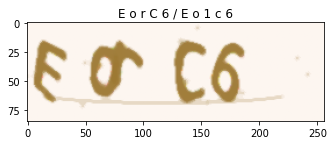

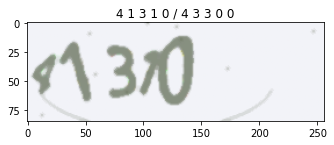

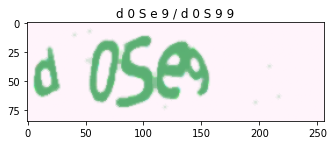

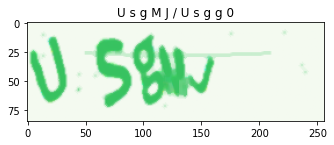

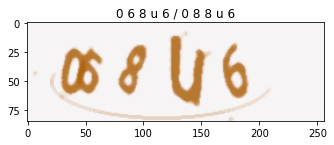

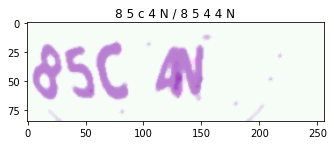

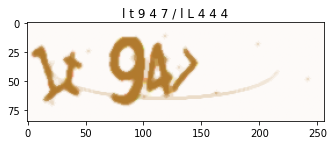

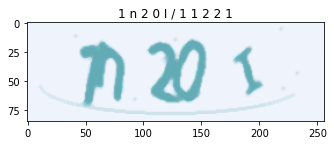

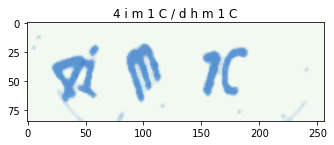

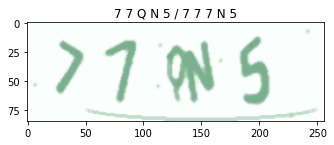

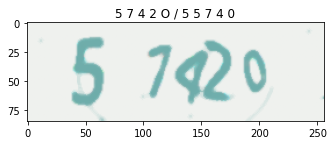

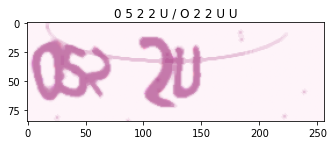

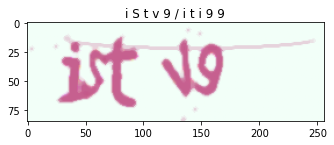

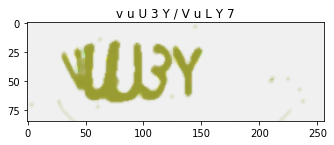

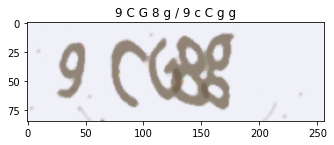

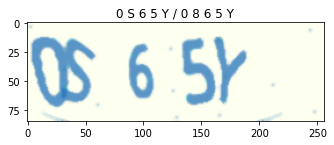

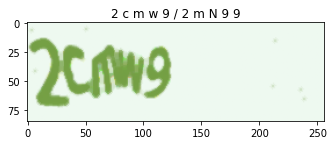

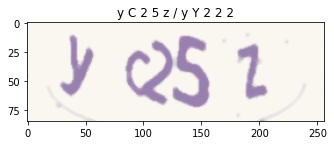

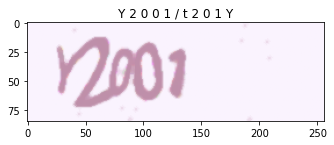

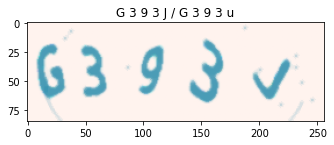

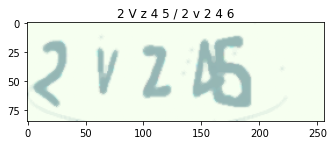

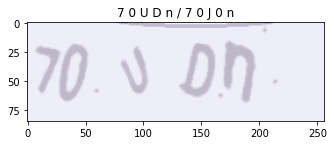

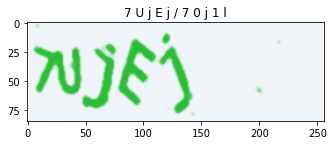

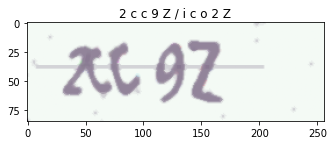

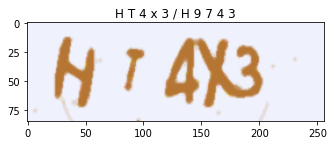

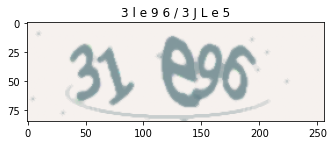

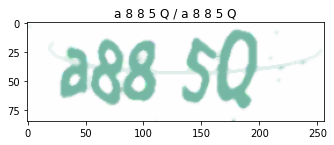

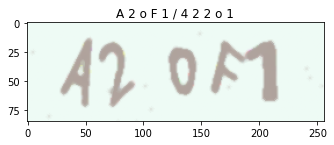

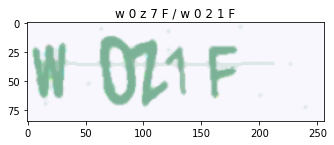

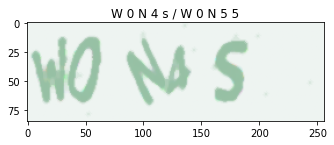

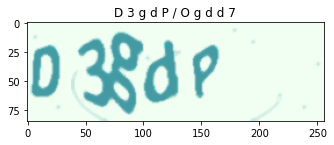

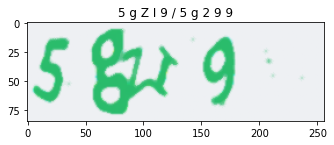

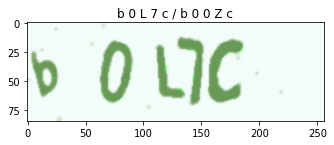

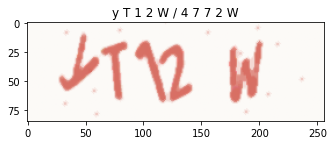

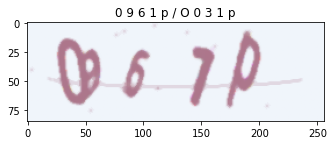

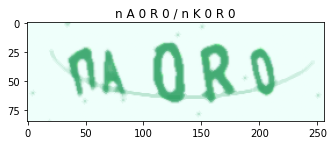

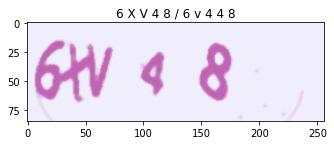

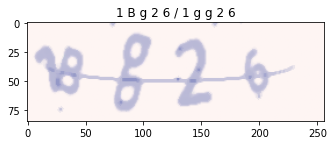

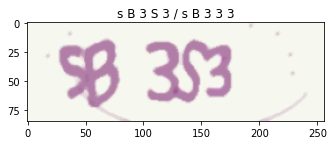

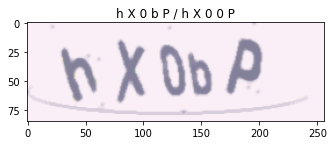

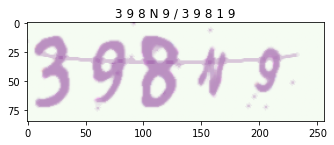

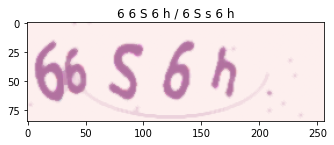

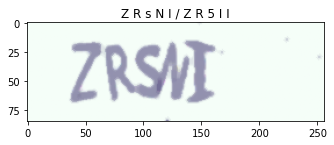

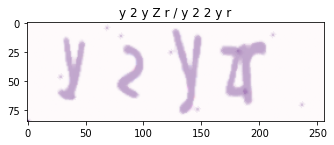

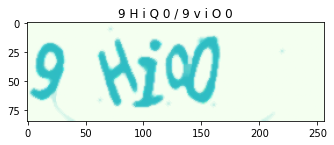

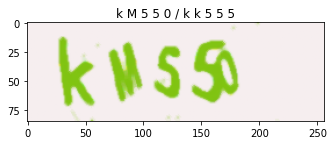

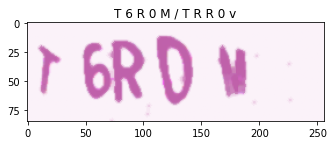

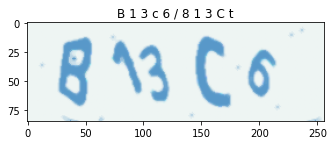

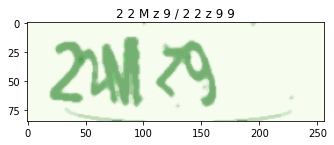

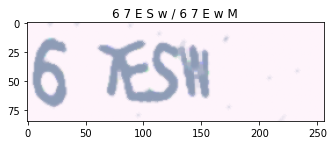

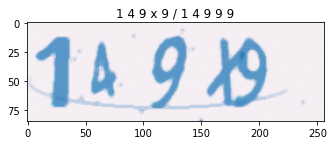

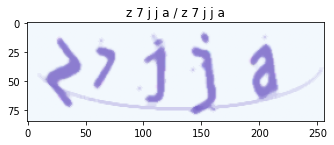

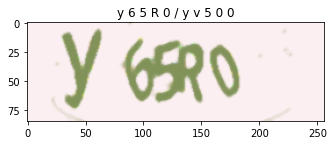

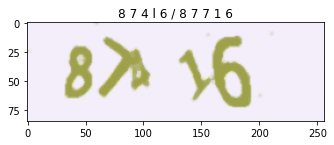

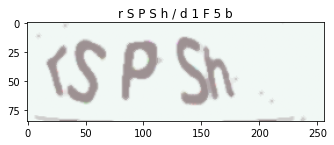

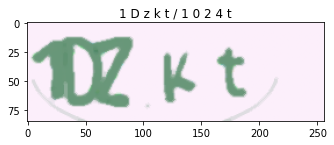

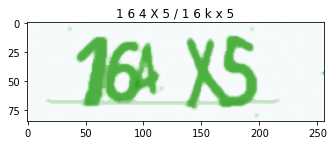

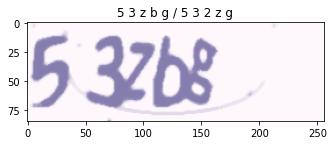

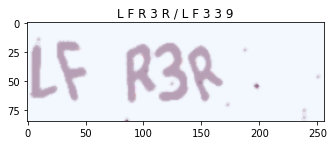

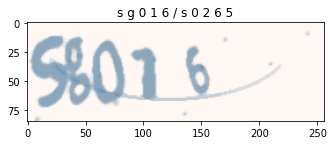

<Figure size 3600x3600 with 0 Axes>

In [22]:
for (x, y) in test_dataloader:
    with torch.no_grad():
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        y1, y2, y3, y4, y5 = y[:, 0], y[:, 1], y[:, 2], y[:, 3], y[:, 4]

        pred1, pred2, pred3, pred4, pred5 = model(x)
        pred1 = torch.argmax(pred1, -1)
        pred2 = torch.argmax(pred2, -1)
        pred3 = torch.argmax(pred3, -1)
        pred4 = torch.argmax(pred4, -1)
        pred5 = torch.argmax(pred5, -1)
        
        y1 = list(map(lambda x: keys[x], y1))
        y2 = list(map(lambda x: keys[x], y2))
        y3 = list(map(lambda x: keys[x], y3))
        y4 = list(map(lambda x: keys[x], y4))
        y5 = list(map(lambda x: keys[x], y5))
        
        pred1 = list(map(lambda x: keys[x], pred1))
        pred2 = list(map(lambda x: keys[x], pred2))
        pred3 = list(map(lambda x: keys[x], pred3))
        pred4 = list(map(lambda x: keys[x], pred4))
        pred5 = list(map(lambda x: keys[x], pred5))
        
        
        for idx in range(BATCH_SIZE):
            true_str = f'{y1[idx]} {y2[idx]} {y3[idx]} {y4[idx]} {y5[idx]}'
            pred_str = f'{pred1[idx]} {pred2[idx]} {pred3[idx]} {pred4[idx]} {pred5[idx]}'
            plt.figure(figsize=(50,50))
            plt.subplot(8, 8, idx+1)
            plt.title(f'{true_str} / {pred_str}')
            plt.imshow(x[idx].detach().cpu().permute(1, 2, 0))
        break